[*********************100%***********************]  20 of 20 completed


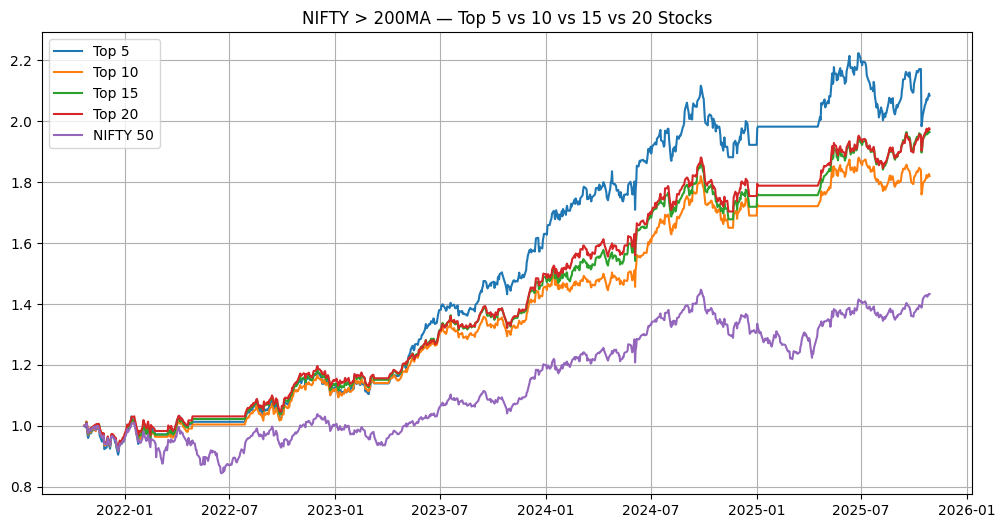


=== Strategy Performance Comparison (Rf = 6%) ===
         Total Return    CAGR Ann. Vol Sharpe (Rf=6%)    MaxDD Win Rate
Top 5         108.46%  20.52%   14.69%           0.94  -11.09%    44.3%
Top 10         82.03%  16.44%   11.87%           0.84   -9.35%    44.0%
Top 15         96.47%  18.71%   11.82%           1.00  -10.34%    45.3%
Top 20         97.45%  18.87%   11.37%           1.05   -9.42%    44.8%
NIFTY 50       43.28%   9.57%   13.89%           0.30  -16.47%    53.1%


In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


nifty_symbol = "^NSEI"

# Top 20 NIFTY stocks (approx 2025 by market cap)
top20 = [
    "AXISBANK.NS",    # Axis Bank Ltd.
    "BAJFINANCE.NS",  # Bajaj Finance Ltd.
    "BHARTIARTL.NS",  # Bharti Airtel Ltd.
    "TATAMOTORS.NS",  # Tata Motors Ltd.
    "HCLTECH.NS",     # HCL Technologies Ltd.
    "HDFCBANK.NS",    # HDFC Bank Ltd.
    "HINDUNILVR.NS",  # Hindustan Unilever Ltd.
    "ICICIBANK.NS",   # ICICI Bank Ltd.
    "ITC.NS",         # ITC Ltd.
    "INFY.NS",        # Infosys Ltd.
    "KOTAKBANK.NS",   # Kotak Mahindra Bank Ltd.
    "LT.NS",          # Larsen & Toubro Ltd.
    "M&M.NS",         # Mahindra & Mahindra Ltd.
    "MARUTI.NS",      # Maruti Suzuki India Ltd.
    "RELIANCE.NS",    # Reliance Industries Ltd.
    "SBIN.NS",        # State Bank of India
    "SUNPHARMA.NS",   # Sun Pharmaceutical Industries Ltd.
    "TCS.NS",         # Tata Consultancy Services Ltd.
    "TITAN.NS",       # Titan Company Ltd.
]

# Portfolio sizes to test
portfolio_sizes = [5, 10, 15, 20]


tickers = [nifty_symbol] + top20
data = yf.download(tickers, start="2021-01-01", end="2025-12-28")["Close"]

nifty = data[nifty_symbol]
stock_data = data[top20]
nifty_ma200 = nifty.rolling(200, min_periods=200).mean()
market_signal = (nifty > nifty_ma200).loc[nifty_ma200.notna()]



stock_data = stock_data.loc[market_signal.index]
nifty = nifty.loc[market_signal.index]

stock_returns = stock_data.pct_change().fillna(0)
nifty_returns = nifty.pct_change().fillna(0)


def run_strategy(selected_stocks):
    subset_returns = stock_returns[selected_stocks]
    filtered_returns = subset_returns.where(market_signal, 0)
    portfolio_returns = filtered_returns.mean(axis=1)
    cum = (1 + portfolio_returns).cumprod()
    return cum


results = {}
for n in portfolio_sizes:
    selected = top20[:n]
    results[f"Top {n}"] = run_strategy(selected)

# Also add NIFTY Buy & Hold for reference
results["NIFTY 50"] = (1 + nifty_returns).cumprod()


plt.figure(figsize=(12,6))
for name, series in results.items():
    plt.plot(series, label=name)
plt.title("NIFTY > 200MA — Top 5 vs 10 vs 15 vs 20 Stocks")
plt.legend()
plt.grid(True)
plt.show()


# Risk-free rate: India 10-yr G-Sec average 2021-2025 ≈ 7.0%
RISK_FREE_RATE = 0.060   # 7.0% per annum

def summary_stats(series):
    ret = series.pct_change().dropna()                
    days = len(ret)
    
    # ----- Basic -----
    total_return = series.iloc[-1] / series.iloc[0] - 1
    cagr = (series.iloc[-1] / series.iloc[0]) ** (252 / days) - 1
    
    # ----- Volatility -----
    ann_vol = ret.std() * np.sqrt(252)
    
    # ----- Sharpe (excess return) -----
    excess_ret = ret.mean() * 252 - RISK_FREE_RATE
    sharpe = excess_ret / ann_vol if ann_vol > 0 else np.nan
    
    # ----- Max Drawdown -----
    cummax = series.cummax()
    drawdown = series / cummax - 1
    max_dd = drawdown.min()          # most negative = deepest drawdown
    
    # ----- Win-rate -----
    win_rate = (ret > 0).mean()
    
    return {
        "Total Return": total_return,
        "CAGR":          cagr,
        "Ann. Vol":      ann_vol,
        "Sharpe (Rf=6%)": sharpe,
        "MaxDD":         max_dd,
        "Win Rate":      win_rate
    }

# Build the table
summary = pd.DataFrame({name: summary_stats(series) for name, series in results.items()}).T

# ----- Pretty formatting -----
formatted = summary.copy()
pct_cols = ["Total Return", "CAGR", "Ann. Vol", "MaxDD"]
for c in pct_cols:
    formatted[c] = formatted[c].map("{:.2%}".format)

formatted["Sharpe (Rf=6%)"] = formatted["Sharpe (Rf=6%)"].map("{:.2f}".format)
formatted["Win Rate"]       = formatted["Win Rate"].map("{:.1%}".format)

print("\n=== Strategy Performance Comparison (Rf = 6%) ===")
print(formatted)

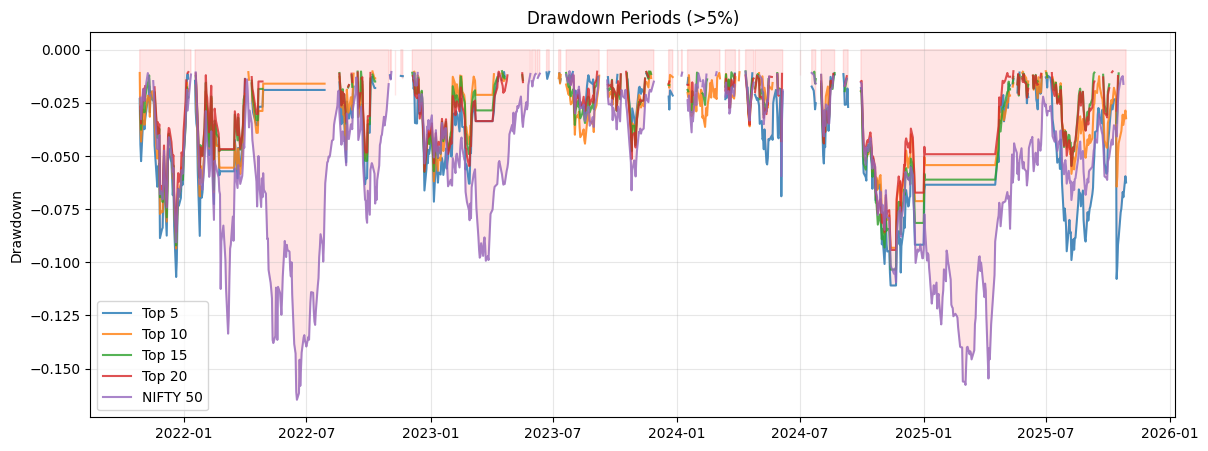

In [8]:
drawdowns = {}
for name, series in results.items():
    cummax = series.cummax()
    dd = series / cummax - 1
    drawdowns[name] = dd

dd_df = pd.DataFrame(drawdowns)
dd_df = dd_df[dd_df < -0.01]  # Show only >5% drawdowns

plt.figure(figsize=(14,5))
for col in dd_df.columns:
    plt.plot(dd_df.index, dd_df[col], label=col, alpha=0.8)
plt.fill_between(dd_df.index, dd_df.min(axis=1), alpha=0.1, color='red')
plt.title("Drawdown Periods (>5%)")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Market signal changes → rebalancing trigger
signal_changes = market_signal.diff().abs().sum()
print(f"Market signal flipped {signal_changes} times → ~{signal_changes/len(market_signal)*100:.1f}% of days require action")
print(f"Avg holding period: {len(market_signal)/signal_changes:.1f} days")

Market signal flipped 30 times → ~3.0% of days require action
Avg holding period: 33.1 days
